In [4]:
# environment
import os
from pathlib import Path
from kaggle.api.kaggle_api_extended import KaggleApi

# data manipulation
import re
import numpy as np
import pandas as pd

# image processing
import cv2 as cv
from PIL import Image
from scipy import ndimage as ndi
from skimage import io, transform, morphology, img_as_bool, segmentation
from skimage.util.shape import view_as_blocks

# plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec

## Prepare Dataset

In [7]:
api = KaggleApi()
api.authenticate()

data_filename = 'bms-molecular-translation'

# get data from kaggle
if not os.path.exists(data_filename):
    api.competition_download_files(data_filename)

In [9]:
# file path info
root_dir  = '~/Documents/kaggle/bms'
data_dir  = os.path.join(root_dir, 'data')
train_dir = os.path.join(data_dir, 'train')
train_csv = os.path.join(data_dir, 'train.csv')
label_csv = os.path.join(data_dir, 'train_labels.csv')
test_dir  = os.path.join(data_dir, 'test')

# data dimensionality
img_width  = 224
img_height = 224

In [11]:
if os.path.exists(train_csv):
    train_df = pd.read_csv(train_csv)

else:
    # create and clean image df
    train_df = (
        pd.read_csv(label_csv)
          .rename(columns=str.lower)
          .assign(inchi_simple=lambda x: x.inchi.apply(
              lambda y: '/'.join(y.split('/', 2)[:2])
           ))
          .assign(image_path=lambda x: x.image_id.apply(
              lambda y: os.path.join(train_dir, y[0], y[1], y[2], y+'.png')
           ))
    )

    # save to csv
    train_df.to_csv(train_csv, index=False)

In [12]:
train_df.sample(10)

,image_id,inchi,inchi_simple,image_path
348469,24bdcf5b61cb,InChI=1S/C16H24N2O3/c1-12-5-6-13(10-15(12)17)1...,InChI=1S/C16H24N2O3,~/Documents/kaggle/bms/data/train/2/4/b/24bdcf...
1600990,a9011f00dea3,InChI=1S/C11H13BrN2OS/c1-7-11(12)9(14(2)13-7)5...,InChI=1S/C11H13BrN2OS,~/Documents/kaggle/bms/data/train/a/9/0/a9011f...
407501,2afc73fb9168,InChI=1S/C6H6ClNO3S/c7-8-5-1-3-6(4-2-5)11-12(9...,InChI=1S/C6H6ClNO3S,~/Documents/kaggle/bms/data/train/2/a/f/2afc73...
313028,20fd7c0d546b,InChI=1S/C21H17FN4O3/c1-12-9-14(7-8-16(12)22)2...,InChI=1S/C21H17FN4O3,~/Documents/kaggle/bms/data/train/2/0/f/20fd7c...
1905300,c927761add6b,InChI=1S/C19H38N2/c1-4-13-20-15-19(12-8-9-17(3...,InChI=1S/C19H38N2,~/Documents/kaggle/bms/data/train/c/9/2/c92776...
853517,5a0ba2b278f0,InChI=1S/C16H13N9O2S/c1-27-11(26)7-10-12-13(25...,InChI=1S/C16H13N9O2S,~/Documents/kaggle/bms/data/train/5/a/0/5a0ba2...
1274711,8682436d7094,InChI=1S/C14H18N2O3/c17-13(18)12-6-2-1-5-11(12...,InChI=1S/C14H18N2O3,~/Documents/kaggle/bms/data/train/8/6/8/868243...
1661892,af7b8bf5200e,InChI=1S/C18H16F4N4OS/c1-2-13-8-14(27)26-16(24...,InChI=1S/C18H16F4N4OS,~/Documents/kaggle/bms/data/train/a/f/7/af7b8b...
2135341,e170c1816d52,"InChI=1S/C21H23NO5S2/c1-16-18(13-14-27-29(3,25...",InChI=1S/C21H23NO5S2,~/Documents/kaggle/bms/data/train/e/1/7/e170c1...
2102317,ddeb8765be3e,InChI=1S/C14H21N3O3/c1-3-11(6-13(18)19)7-16-14...,InChI=1S/C14H21N3O3,~/Documents/kaggle/bms/data/train/d/d/e/ddeb87...


## Example Images

In [13]:
def pad_to_square(img):
    """
    Pads grayscale image with zeros until square-shaped.
    """
    m, n = img.shape
    n_pad = abs(m-n) // 2
    if m > n:
        padding = ((0, 0), (n_pad, n_pad))
    else:
        padding = ((n_pad, n_pad), (0, 0))
    return np.pad(img, padding, mode='constant')

In [14]:
def invert(img):
    """
    Inverts grayscale image.
    """
    return 255 - img

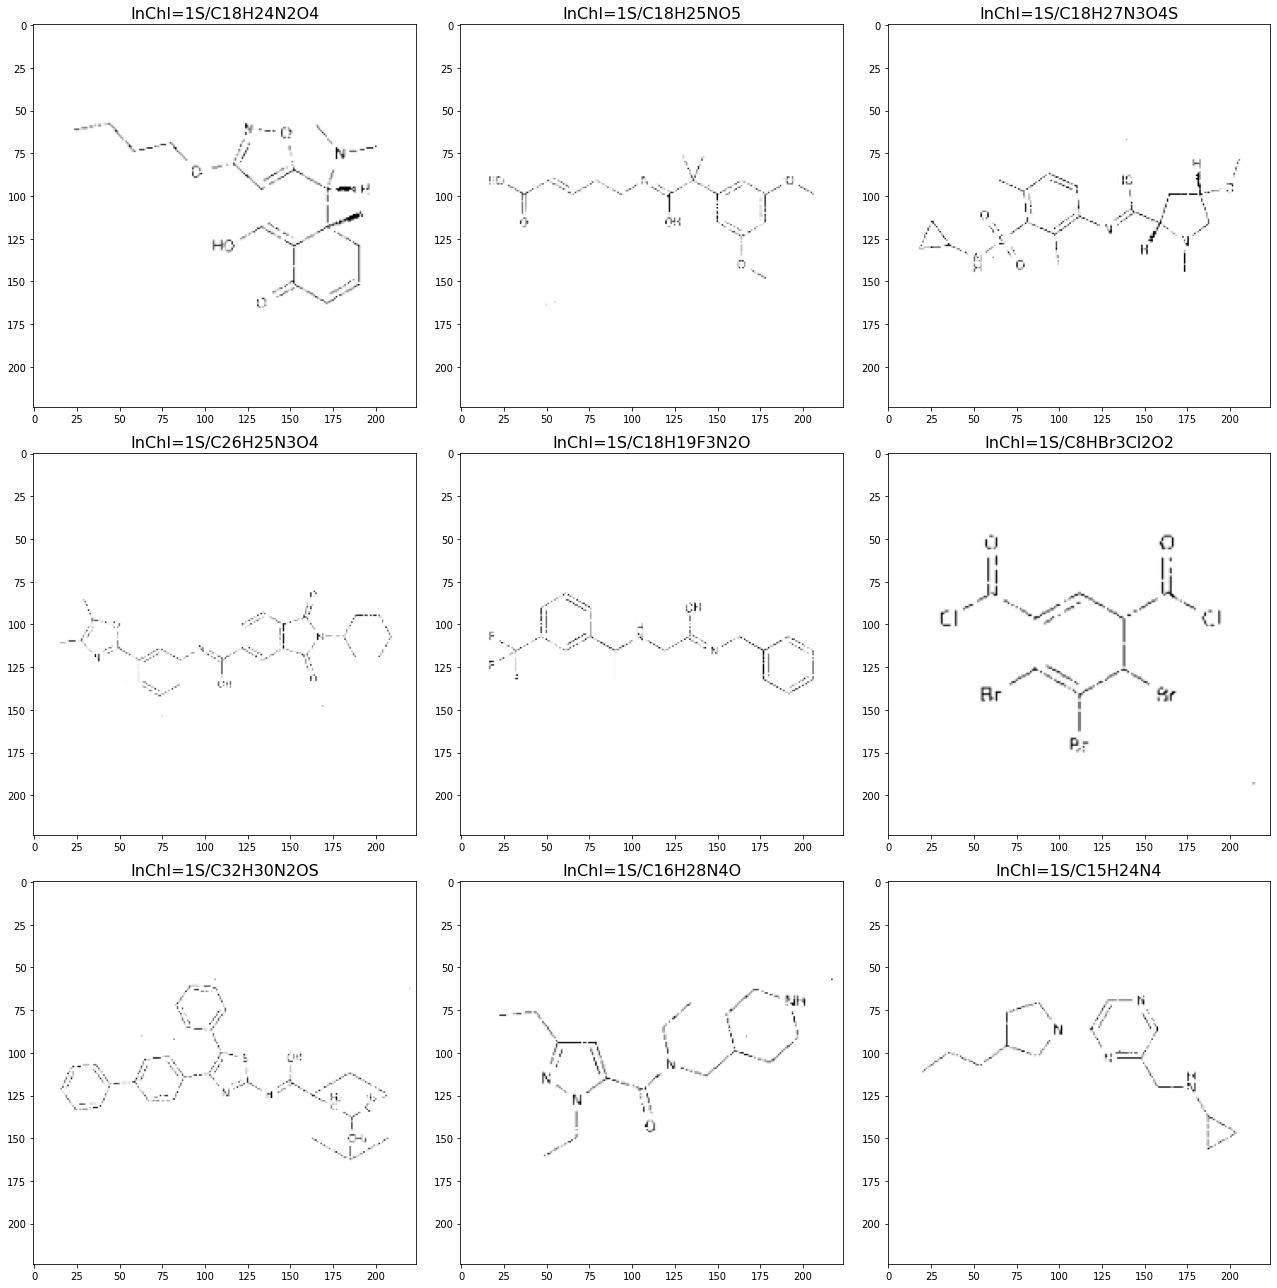

In [15]:
rows = 3
cols = 3

sample = train_df.sample(rows*cols)

# define subplot arrangement
gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize=(18, 18))

# kernel = np.ones((2, 2))

for i, (idx, _) in enumerate(sample.iterrows()):
    img_path = sample.at[idx, 'image_path']
    inchi_simple = sample.at[idx, 'inchi_simple']

    # load, square, invert
    img = io.imread(img_path)
    img = pad_to_square(invert(img))
    
    # transform
    # if img.shape[0] > 1.50 * img_width:
    #     img = cv.dilate(img, kernel)
    #     img = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)
        
    img = cv.resize(img, (img_width, img_height))

    # plot sample image
    ax = fig.add_subplot(gs[i])
    ax.imshow(img, cmap='Greys')
    ax.set_title(inchi_simple, fontsize=16)
    
plt.tight_layout()
plt.show()

## Extract Tokens

#### Simple Chemical Tokens

In [16]:
# ignore prefix (InChI=1S/)
simple_labels = [s.split('/')[1] for s in train_df.inchi_simple]

# extract tokens (elements and numbers)
tokens = [t for s in simple_labels for t in re.findall('(\d+|[A-Z][a-z]*)', s)]
tokens = sorted(list(set(tokens)), reverse=True)

In [19]:
# include missing numbers
tokens_simple = ['<START>', '<PAD>', '<END>', 'InChI=1S/']    \
              + tokens[:12] + [str(i) for i in range(1, 168)]

In [20]:
print(tokens_simple)

['<START>', '<PAD>', '<END>', 'InChI=1S/', 'Si', 'S', 'P', 'O', 'N', 'I', 'H', 'F', 'Cl', 'C', 'Br', 'B', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '

#### Full Chemical Tokens

In [21]:
# additional tokens present in full formulas
add_tokens = [t for s in train_df.inchi for t in re.findall('/[a-z]', s)]
add_tokens = list(set(add_tokens)) + ['D', 'T', '+', '-', ',']

In [23]:
tokens_full = tokens_simple[:-3] + add_tokens + tokens_simple[-3:]

In [24]:
print(tokens_full)

['<START>', '<PAD>', '<END>', 'InChI=1S/', 'Si', 'S', 'P', 'O', 'N', 'I', 'H', 'F', 'Cl', 'C', 'Br', 'B', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '